# Summary

My goal was to create a predictive regression model for bike rental demand for total count. I used three algorithms (linear regression, decision trees, and random forests). My success metric was RMSE.

First, I split the data into 80% train and 20% test to simulate some holdout data. Then, I engineered some labels for a DecisionTreeRegressor and compared the MSE of its predictions with the MSE of a similar Linear Regression model. The data has many columns that would be more informative in a categorical format versus a numerical one. This is the reason that a Linear Regression did not perform as well as a RandomForest.

Some patterns found in this project:

- There are more rentals in 2012 than 2011, research shows that Washington D.C. expanded their bikeshare program at the end of 2011.
- Warm weather increases rentals and peaks in Summer Months
- Registered and casual user groups have an inverse weekday/weekend relationship, with registered users having consistent usage throughout the work week.
- Registered user rentals peak during commuting hours (7:00-9:00 a.m. and 6:00-7:00 p.m.).
- Casual user rentals follow a normal distribution between 7:00 am and midnight with peak usage between noon and 6:00 p.m.
- Extreme weather causes a drop in bikeshare usage, though registered users are more resilient.

### Performance
- Random Forests performed best out of the 3
- Random Forest with 100 estimators:
    - Best Parameters: {'max_leaf_nodes': 1690, 'min_samples_leaf': 2, 'min_samples_split': 2}
    - Best MSE: 1879.142
    - Best RMSE: 43.349

Predicting the total users is simpler and more generalized than trying to predict smaller casual and registered user groups. There is an opportunity to improve the predictions with further feature engineering targeted at the specified groups.

# Introduction

Washington, D.C. has communal bike sharing stations where you can rent bicycles by the hour or day. The District collects detailed data on the number of bicycles people rent by the hour and day.

[Hadi Fanaee-T](http://www.fanaee.com/) now at the University of Oslo, Norway compiled this data into a CSV file for this project. The file contains 17380 rows, with each row representing the number of bike rentals for a single hour of a single day. The data can be found from the [University of California, Irvine's website](https://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset).

I will try to predict the total number of bikes people rented in a given hour. I will predict the `cnt` column using all of the other columns, except for `casual` and `registered` since these columns are just the `cnt` column split into type of user. To accomplish this, I will create a few different machine learning models and evaluate their performance.


> Bike sharing systems are new generation of traditional bike rentals where whole process from membership, rental and return back has become automatic. Through these systems, user is able to easily rent a bike from a particular position and return back at another position. Currently, there are about over 500 bike-sharing programs around the world which is composed of over 500 thousands bicycles. Today, there exists great interest in these systems due to their important role in traffic, environmental and health issues.
>
> Apart from interesting real world applications of bike sharing systems, the characteristics of data being generated by these systems make them attractive for the research. Opposed to other transport services such as bus or subway, the duration of travel, departure and arrival position is explicitly recorded in these systems. This feature turns bike sharing system into a virtual sensor network that can be used for sensing mobility in the city. Hence, it is expected that most of important events in the city could be detected via monitoring these data.

| Column Name | Description                                                                                                                                 |
|-------------|---------------------------------------------------------------------------------------------------------------------------------------------|
| instant     | record index                                                                                                                                |
| dteday      | date                                                                                                                                        |
| season      | season (1: winter, 2: spring, 3: summer, 4: fall)                                                                                               |
| yr          | year (0: 2011, 1: 2012)                                                                                                                      |
| mnth        | month (1 to 12)                                                                                                                            |
| hr          | hour (0 to 23)                                                                                                                              |
| holiday     | weather day is holiday or not                                                                                   |
| weekday     | day of the week                                                                                                                             |
| workingday  | if day is neither weekend nor holiday is 1, otherwise is 0                                                                                  |
| weathersit  | 1: Clear, Few clouds, Partly cloudy, Partly cloudy                                                                                          |
|             | 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist                                                                             |
|             | 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds                                                  |
|             | 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog                                                                               |
| temp        | Normalized temperature in Celsius. The values are derived via (t-t_min)/(t_max-t_min), t_min=-8, t_max=+39 (only in hourly scale)           |
| atemp       | Normalized feeling temperature in Celsius. The values are derived via (t-t_min)/(t_max-t_min), t_min=-16, t_max=+50 (only in hourly scale)  |
| hum         | Normalized humidity. The values are divided to 100 (max)                                                                                    |
| windspeed   | Normalized wind speed. The values are divided to 67 (max)                                                                                   |
| casual      | count of casual users                                                                                                                       |
| registered  | count of registered users                                                                                                                   |
| cnt         | count of total rental bikes including both casual and registered                                                                            |


## Imports

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from datetime import datetime, timedelta
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import joblib

pd.options.display.max_columns = 20
plt.style.use('fivethirtyeight')

In [3]:
bike_rentals = pd.read_csv('data/hour.csv')
bike_rentals.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     17379 non-null  int64  
 1   dteday      17379 non-null  object 
 2   season      17379 non-null  int64  
 3   yr          17379 non-null  int64  
 4   mnth        17379 non-null  int64  
 5   hr          17379 non-null  int64  
 6   holiday     17379 non-null  int64  
 7   weekday     17379 non-null  int64  
 8   workingday  17379 non-null  int64  
 9   weathersit  17379 non-null  int64  
 10  temp        17379 non-null  float64
 11  atemp       17379 non-null  float64
 12  hum         17379 non-null  float64
 13  windspeed   17379 non-null  float64
 14  casual      17379 non-null  int64  
 15  registered  17379 non-null  int64  
 16  cnt         17379 non-null  int64  
dtypes: float64(4), int64(12), object(1)
memory usage: 2.2+ MB


# Exploration

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


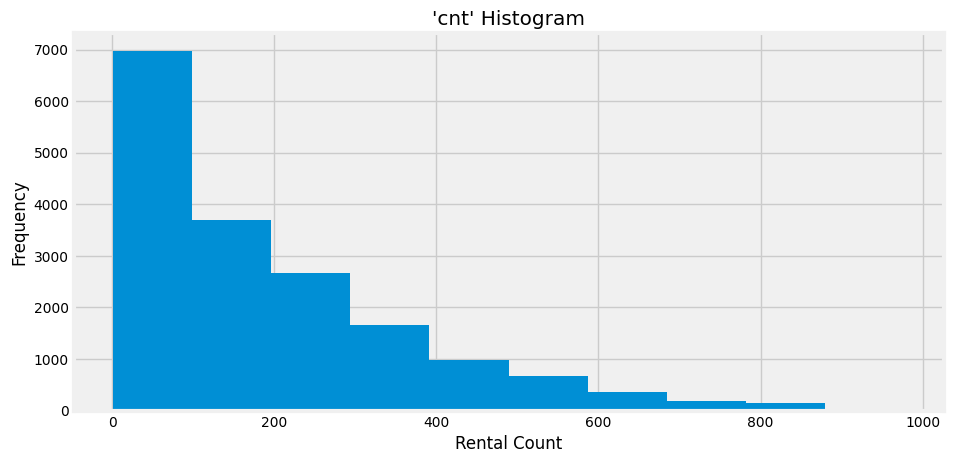

In [4]:
display(bike_rentals.head())

plt.figure('cnthist', figsize=(10,5), dpi=100)
bike_rentals['cnt'].hist()
plt.title('\'cnt\' Histogram')
plt.xlabel('Rental Count')
plt.ylabel('Frequency')
plt.show()

In [5]:
bike_rentals.corr()['cnt'].sort_values(ascending=False)

cnt           1.000000
registered    0.972151
casual        0.694564
temp          0.404772
atemp         0.400929
hr            0.394071
instant       0.278379
yr            0.250495
season        0.178056
mnth          0.120638
windspeed     0.093234
workingday    0.030284
weekday       0.026900
holiday      -0.030927
weathersit   -0.142426
hum          -0.322911
Name: cnt, dtype: float64

In [99]:
season_groupby = bike_rentals.groupby('season')[['casual', 'registered', 'cnt']].sum()
week_groupby = bike_rentals.groupby('weekday')[['casual', 'registered', 'cnt']].sum()
weather_groupby = bike_rentals.groupby('weathersit')[['casual', 'registered', 'cnt']].sum()
hr_groupby = bike_rentals.groupby('hr')[['casual', 'registered', 'cnt']].sum()
day_groupby_groups = bike_rentals.groupby('weekday')

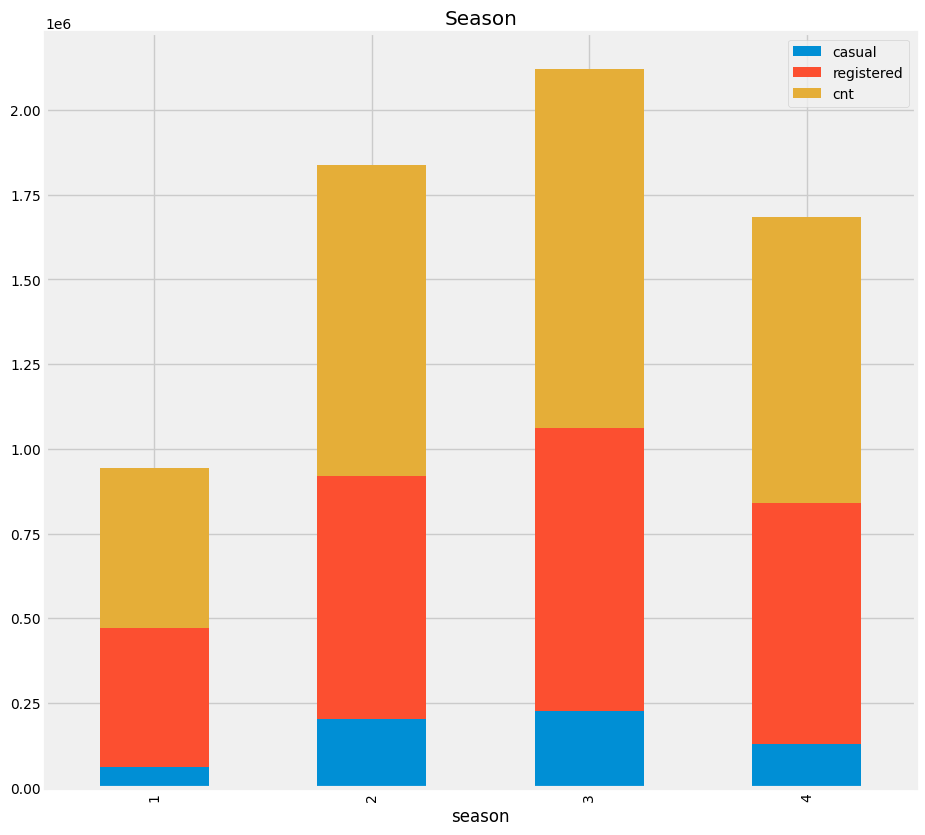

In [82]:
fig, ax = plt.subplots(figsize=(10,10), dpi=100)
season_groupby.plot.bar(ax=ax, stacked=True)
plt.title('Season')
plt.show()

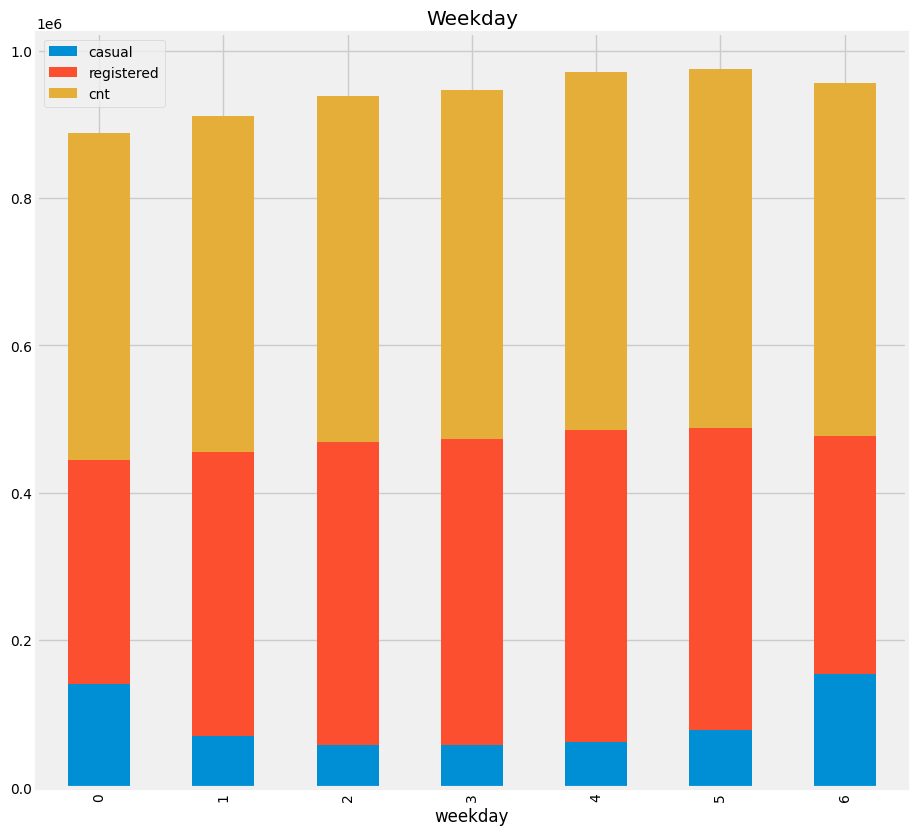

In [84]:
fig, ax = plt.subplots(figsize=(10,10), dpi=100)
week_groupby.plot.bar(ax=ax, stacked=True)
plt.title('Weekday')
plt.show()

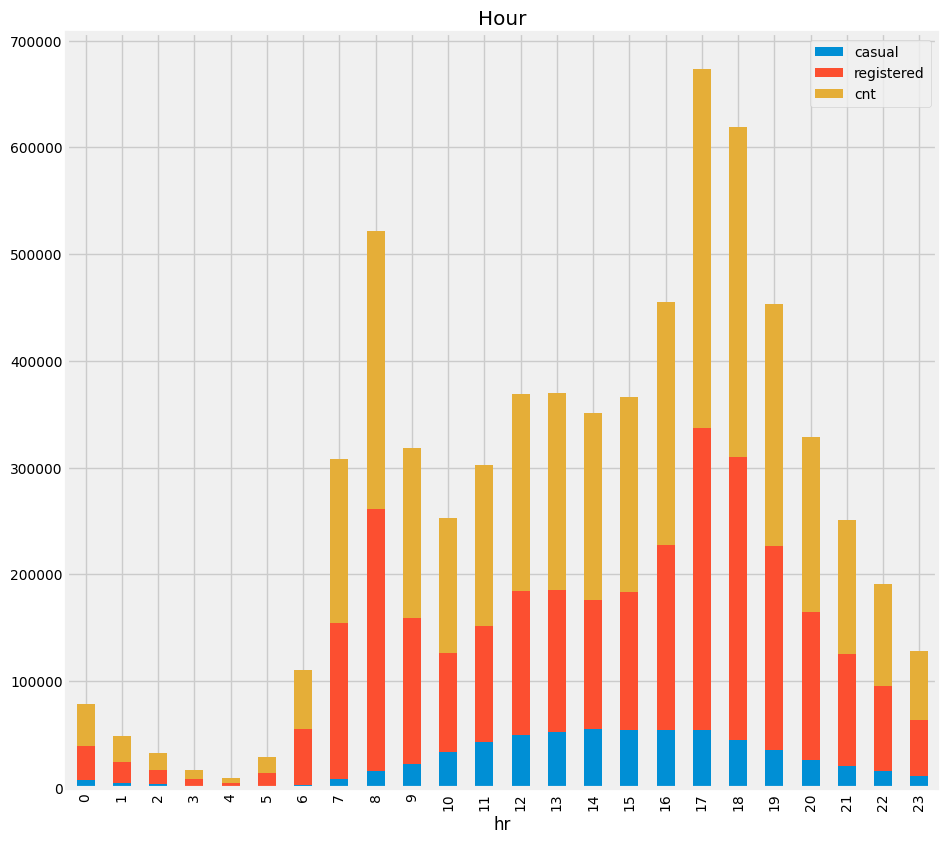

In [98]:
fig, ax = plt.subplots(figsize=(10,10), dpi=100)
hr_groupby.plot.bar(ax=ax, stacked=True)
plt.title('Hour')
plt.show()

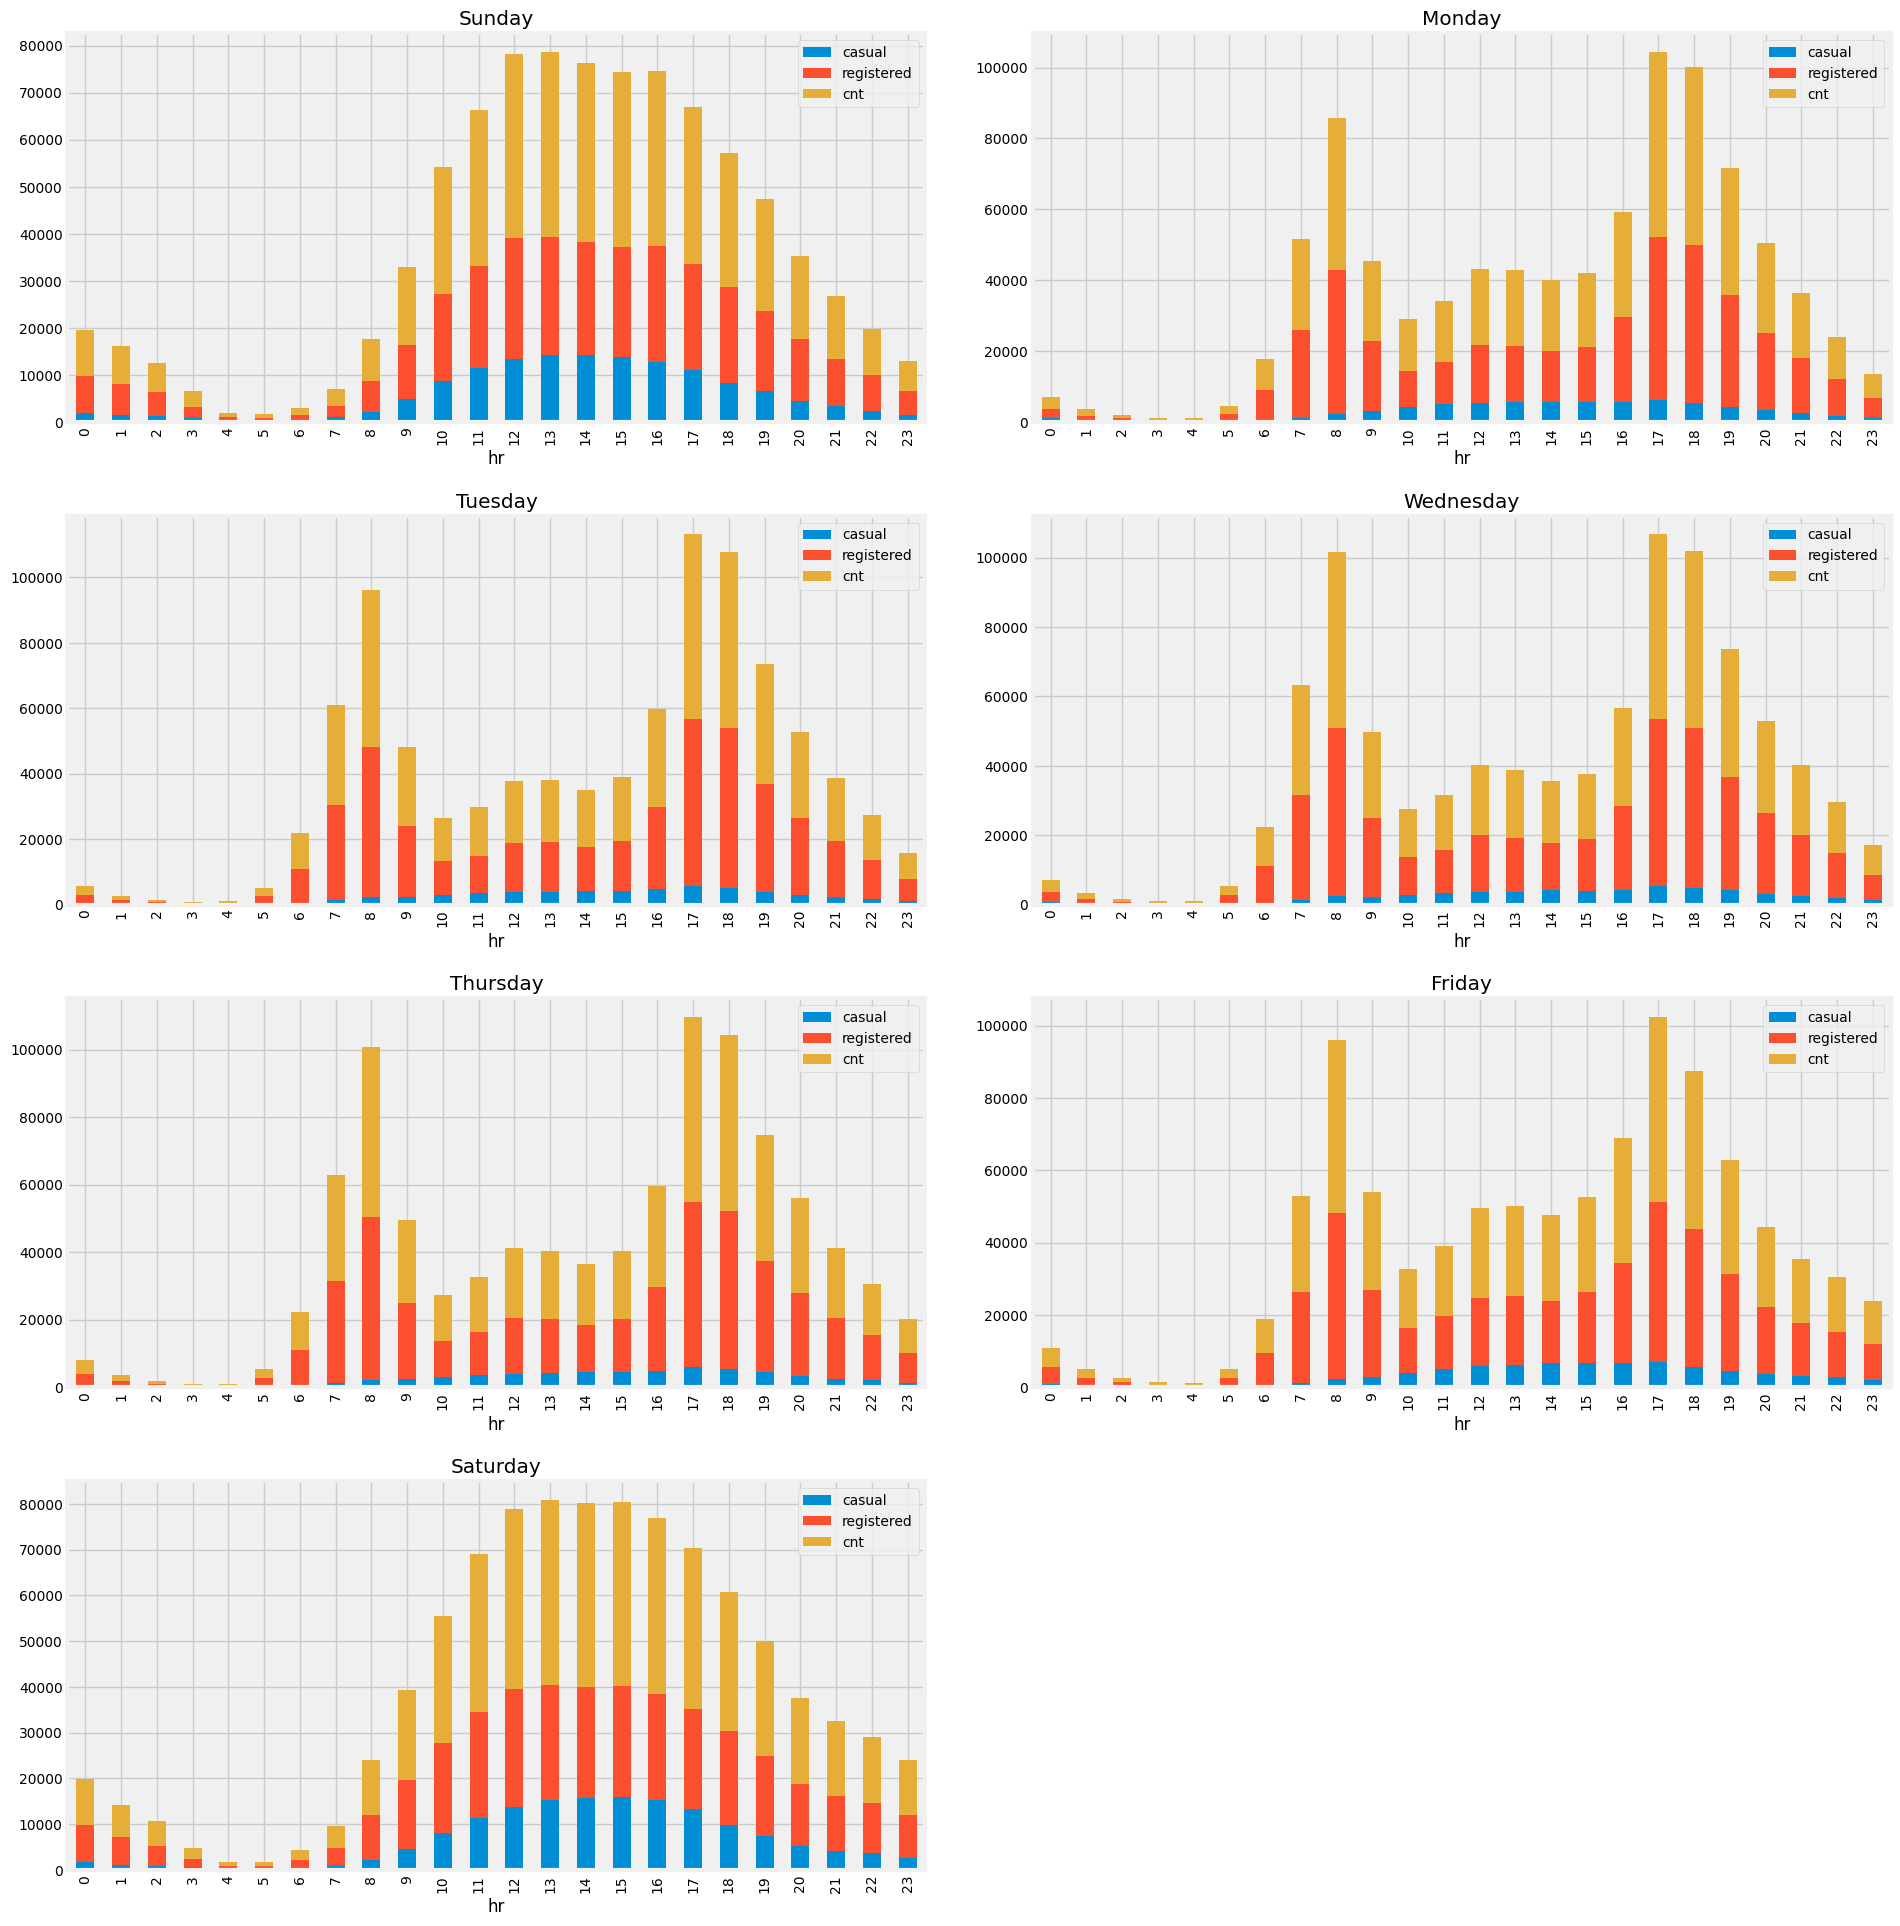

In [120]:
fig, ax = plt.subplots(4,2, figsize=(20,20), dpi=100)
fig.tight_layout(pad=5)
ax = ax.flat
dict_of_days = {0: 'Sunday', 1: 'Monday', 2: 'Tuesday', 3: 'Wednesday', 4: 'Thursday', 5: 'Friday', 6: 'Saturday'}
for each in day_groupby_groups.groups.keys():
    day_groupby_groups.get_group(each).groupby('hr')[['casual', 'registered', 'cnt']].sum().plot.bar(ax=ax[each], stacked=True)
    ax[each].set_title('{}'.format(dict_of_days[each]))

fig.delaxes(ax[7])    
plt.show()

# Changing Labels

The time columns are not very useful as just numbers. If they were categorized with labels then we can generalize the trends of those specific time periods.

In [7]:
def label_hour(hour):
    if (hour < 0) | (hour > 24):
        return -1
    elif (hour < 6):
        return 4
    elif (hour < 12):
        return 1
    elif (hour < 18):
        return 2
    else:
        return 3

In [8]:
bike_rentals['time_label'] = bike_rentals['hr'].apply(label_hour)
bike_rentals['time_label'].describe()

count    17379.000000
mean         2.492548
std          1.115284
min          1.000000
25%          1.000000
50%          2.000000
75%          3.000000
max          4.000000
Name: time_label, dtype: float64

In [9]:
bike_rentals['cnt'].describe()

count    17379.000000
mean       189.463088
std        181.387599
min          1.000000
25%         40.000000
50%        142.000000
75%        281.000000
max        977.000000
Name: cnt, dtype: float64

Mean Squared Error may be the easiest error metric to measure my model's prediction accuracy of the `cnt` column. The column is continuous and numeric which fits well for MSE.

In [10]:
train = bike_rentals.sample(frac=.8)
test = bike_rentals.loc[~bike_rentals.index.isin(train.index)]

Linear Regression may not be the best model suited for `cnt` as it does not have an compelling correlation to most of the other columns, but it is the simplest. I will build a Linear Model first, and then develop a random forest from a decision tree.

In [11]:
nothelpful = ['cnt', 'casual', 'registered', 'dteday', 'instant']
features = ['hr', 'holiday', 'workingday', 'weathersit', 'atemp', 'temp']
lr = LinearRegression()

These are the features I think will be most helpful in predicting `cnt` without any further manipulation. Some of the weather descriptors should be rearranged for a more direct correlation. For example, I believe that most people would like to ride their bike in good moderate weather: sunny, clear skies, low to medium humidity, moderate temperatures, low windspeed, and during the day. The prediction accuracy would increase if there was a way to combine these columns into a score.

In [12]:
lr.fit(train[features], train['cnt'])
predictions = lr.predict(test[features])

mse = mean_squared_error(test['cnt'], predictions)
print('MSE: {0:.3f}'.format(mse))
print('RMSE: {0:.3f}'.format(np.sqrt(mse)))

MSE: 23630.869
RMSE: 153.723


In [13]:
features = bike_rentals.columns.drop(nothelpful)

lr.fit(train[features], train['cnt'])
predictions = lr.predict(test[features])

mse = mean_squared_error(test['cnt'], predictions)
print('MSE: {0:.3f}'.format(mse))
print('RMSE: {0:.3f}'.format(np.sqrt(mse)))

MSE: 17636.188
RMSE: 132.801


Even using all the numerical columns, except the ones related to raw rental count, as features did not produce a significant decrease in error.

In [14]:
cnt_corr = bike_rentals.corr()['cnt']
features = cnt_corr[cnt_corr >= .3].index
features = features[~features.isin(nothelpful)]

lr.fit(train[features], train['cnt'])
predictions = lr.predict(test[features])

mse = mean_squared_error(test['cnt'], predictions)
print('MSE: {0:.3f}'.format(mse))
print('RMSE: {0:.3f}'.format(np.sqrt(mse)))

MSE: 23998.632
RMSE: 154.915


Using all the columns as predictors lowers our error significantly (15%), but further tuning will not provide much better accuracies, seeing that removing more features increases the error. I can try a decision tree which is better suited for nonlinear datasets.

# Decision Tree

## Default Parameters

In [15]:
dtr = DecisionTreeRegressor()

features = bike_rentals.columns.drop(nothelpful)
dtr.fit(train[features], train['cnt'])
predictions = dtr.predict(test[features])

mse = mean_squared_error(test['cnt'], predictions)
print('MSE: {0:.3f}'.format(mse))
print('RMSE: {0:.3f}'.format(np.sqrt(mse)))
print('Leaves:', dtr.get_n_leaves())
print('Depth:', dtr.get_depth())

MSE: 3723.990
RMSE: 61.025
Leaves: 13144
Depth: 31


In [16]:
def fit_predict_mse(dtr, features, p=True):
    dtr.fit(train[features], train['cnt'])
    predictions = dtr.predict(test[features])

    mse = mean_squared_error(test['cnt'], predictions)
    if p:
        print('MSE: {0:.3f}'.format(mse))
        print('RMSE: {0:.3f}'.format(np.sqrt(mse)))
    return predictions, mse

In [17]:
def multi_predict(num, dtr, features, p=False):
    predictions = []
    for _ in range(num):
        predictions.append(fit_predict_mse(dtr, features, p=p)[1])
    
    return predictions

## min_samples_leaf

In [18]:
dtr = DecisionTreeRegressor(min_samples_leaf=6)
predictions = multi_predict(100, dtr, features)
print('MSE: {0:.3f}'.format(np.mean(predictions)))
print('RMSE: {0:.3f}'.format(np.sqrt(mse)))
print('Leaves:', dtr.get_n_leaves())
print('Depth:', dtr.get_depth())

MSE: 2788.439
RMSE: 61.025
Leaves: 1834
Depth: 23


 I found that a minimum of 6 samples in a leaf node produces the least error

In [19]:
dtr = DecisionTreeRegressor(min_samples_split=2, min_samples_leaf=6, max_leaf_nodes=820)
predictions = multi_predict(100, dtr, features)
print('MSE: {0:.3f}'.format(np.mean(predictions)))
print('RMSE: {0:.3f}'.format(np.sqrt(mse)))
print('Leaves:', dtr.get_n_leaves())
print('Depth:', dtr.get_depth())

MSE: 2786.739
RMSE: 61.025
Leaves: 820
Depth: 20


I experimented with almost all the leaf and depth parameters and these are the ones that can decrease the error lower than just only `min_samples_leaf`.

The error of a decision tree for this data shows a substantial improvement in prediction accuracy over a Linear Regression. I think I may get better errors with a Random Forest.

# Random Forest

In [20]:
rfr = RandomForestRegressor(n_jobs=-2, n_estimators=100)
print(features)
results = fit_predict_mse(rfr, features, True)

Index(['season', 'yr', 'mnth', 'hr', 'holiday', 'weekday', 'workingday',
       'weathersit', 'temp', 'atemp', 'hum', 'windspeed', 'time_label'],
      dtype='object')
MSE: 1840.925
RMSE: 42.906


Compared to the single decision tree the error of a Random Forest decreased further, but not as much as Linear Regression to Decision Tree.

In [21]:
importances = pd.Series(rfr.feature_importances_, index=rfr.feature_names_in_)
std = pd.Series(np.array([tree.feature_importances_ for tree in rfr.estimators_]).std(axis=0), 
index=rfr.feature_names_in_
)
importances.sort_values(ascending=False)

hr            0.605277
temp          0.124755
yr            0.079212
workingday    0.056012
hum           0.027504
season        0.021758
atemp         0.020880
weathersit    0.017978
mnth          0.016118
weekday       0.013723
windspeed     0.010571
time_label    0.003991
holiday       0.002221
dtype: float64

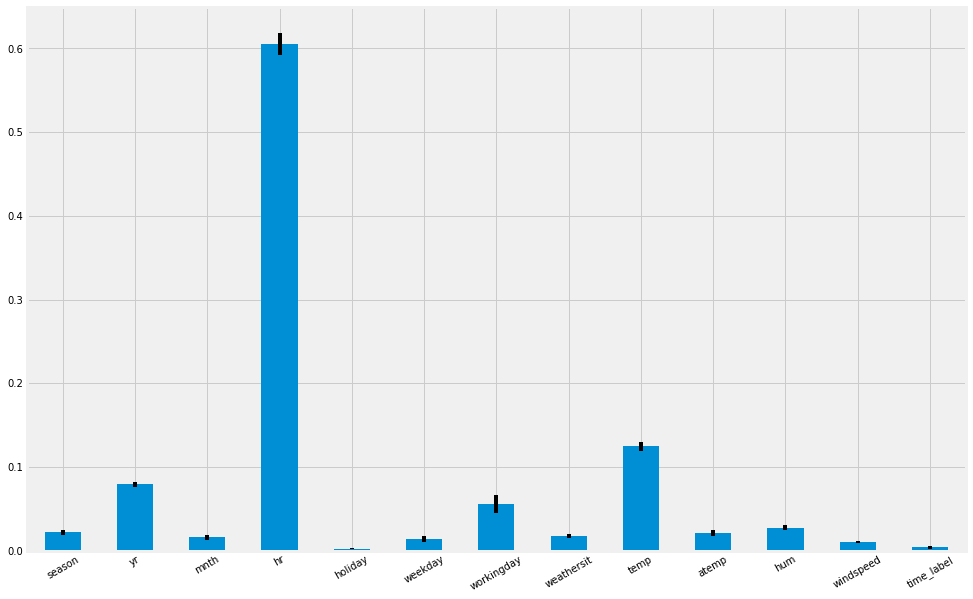

In [22]:
fig, ax = plt.subplots(figsize=(15,10))
importances.plot.bar(yerr=std, ax=ax, rot=30)

plt.show()

The most import features are `hr` and `temp`

### Randomized Search to start initial Hyperparameter Tuning

I have the files dumped and loaded in the local directory and comment out the searching to speed up run times

In [23]:
pickle_file = './grid-search-results-1.pkl'
best_file = './best-1.pkl'

rfr = RandomForestRegressor(n_jobs=-2, n_estimators=100)

leaf_lim = range(1650, 1750, 1)
samples_split = range(2, 4)
samples_leaf = range(2, 4)

param_grid = {
    'max_leaf_nodes': leaf_lim,
    'min_samples_split': samples_split,
    'min_samples_leaf': samples_leaf
    }

# gs = RandomizedSearchCV(estimator=rfr, param_distributions=param_grid, scoring='neg_mean_squared_error', n_jobs=-2)

# with open(pickle_file, 'wb') as f:
#     gs.fit(train[features], train['cnt'])
#     joblib.dump(gs, f)

# best = [gs.best_params_, gs.best_estimator_, gs.cv_results_]
# with open(best_file, 'wb') as f:
#     joblib.dump(best, f)

# gs.fit(train[features], train['cnt'])
# print('Best Parameters: {}'.format(gs.best_estimator_))
# print('Best MSE: {:.3f}'.format(-gs.best_score_))

In [24]:
best_params, best_est, cv_results = joblib.load(best_file)
best_rfr = joblib.load(pickle_file)

print('Best Parameters: {}'.format(best_params))
print('Best MSE: {:.3f}'.format(-best_rfr.best_score_))
print('Best RMSE: {0:.3f}'.format(np.sqrt(-best_rfr.best_score_)))

Best Parameters: {'min_samples_split': 2, 'min_samples_leaf': 2, 'max_leaf_nodes': 1669}
Best MSE: 1884.488
Best RMSE: 43.411


After trying a few different ranges that the lowest errors have: 

'max_leaf_nodes': 1600 - 1700 

'min_samples_leaf': 2 

'min_samples_split': 2

### Grid Search within a more defined, narrow range

In [25]:
pickle_file = './grid-search-results-2.pkl'
best_file = './best-2.pkl'

# rfr = RandomForestRegressor(n_jobs=-2, n_estimators=100)

# leaf_lim = range(1600, 1700, 5)
# samples_split = range(2, 4)
# samples_leaf = range(2, 4)
# param_grid = {'max_leaf_nodes': leaf_lim, 
# 'min_samples_split': samples_split,
# 'min_samples_leaf': samples_leaf
# }

# gs = GridSearchCV(estimator=rfr, param_grid=param_grid, scoring='neg_mean_squared_error', n_jobs=-2)

# with open(pickle_file, 'wb') as f:
#     gs.fit(train[features], train['cnt'])
#     joblib.dump(gs, f)

# best = [gs.best_params_, gs.best_estimator_, gs.cv_results_]
# with open(best_file, 'wb') as f:
#     joblib.dump(best, f)

In [26]:
best_params, best_est, cv_results = joblib.load(best_file)
best_rfr = joblib.load(pickle_file)

print('Best Parameters: {}'.format(best_params))
print('Best MSE: {:.3f}'.format(-best_rfr.best_score_))
print('Best RMSE: {0:.3f}'.format(np.sqrt(-best_rfr.best_score_)))

Best Parameters: {'max_leaf_nodes': 1690, 'min_samples_leaf': 2, 'min_samples_split': 2}
Best MSE: 1879.142
Best RMSE: 43.349


### Observing the Feature Importances of the best RandomForest

In [27]:
importances = pd.Series(best_est.feature_importances_, index=best_est.feature_names_in_)
std = pd.Series(np.array([tree.feature_importances_ for tree in best_est.estimators_]).std(axis=0), 
index=best_est.feature_names_in_
)
importances.sort_values(ascending=False)

hr            0.613706
temp          0.118302
yr            0.080341
workingday    0.060315
hum           0.024952
season        0.021664
atemp         0.020743
weathersit    0.018398
mnth          0.014201
weekday       0.012564
windspeed     0.007977
time_label    0.004533
holiday       0.002303
dtype: float64

In [28]:
print('Best Parameters: {}'.format(best_params))
print('Best MSE: {:.3f}'.format(-best_rfr.best_score_))
print('Best RMSE: {0:.3f}'.format(np.sqrt(-best_rfr.best_score_)))

Best Parameters: {'max_leaf_nodes': 1690, 'min_samples_leaf': 2, 'min_samples_split': 2}
Best MSE: 1879.142
Best RMSE: 43.349


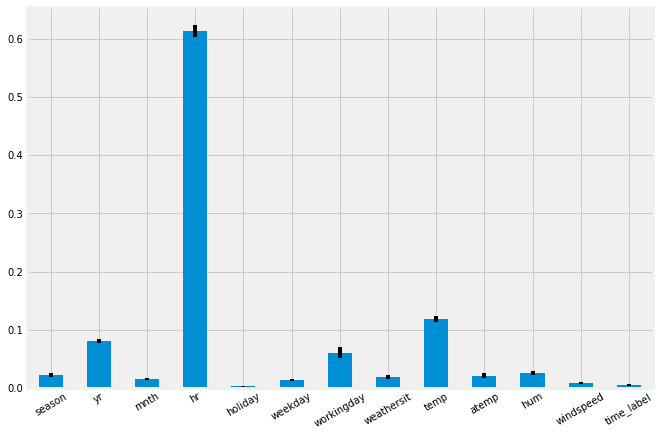

In [29]:
fig, ax = plt.subplots(figsize=(10,7))
importances.plot.bar(yerr=std, ax=ax, rot=30)

plt.show()

### Visualization of my best RandomForest

In [30]:
results_df = pd.DataFrame(cv_results)

In [31]:
best_predictions = pd.Series(best_est.predict(test[features]), name='prediction')
best_predictions = pd.concat([test['cnt'].reset_index().rename(columns={'index': 'old_cnt_index'}), best_predictions], axis=1)
best_predictions.insert(0, 'old_cnt_index', best_predictions.pop('old_cnt_index'))
best_predictions.insert(1, 'dteday', pd.to_datetime(test['dteday'].reset_index(drop=True)))
best_predictions.insert(2, 'hr', test['hr'].reset_index(drop=True))
best_predictions['error'] = np.abs(best_predictions['cnt'] - best_predictions['prediction'])
less_than_100 = best_predictions[best_predictions['cnt'] <= 100]

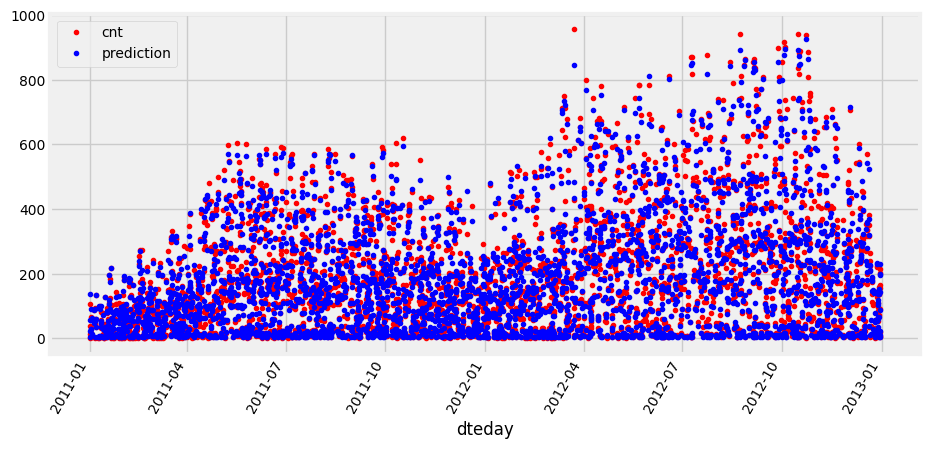

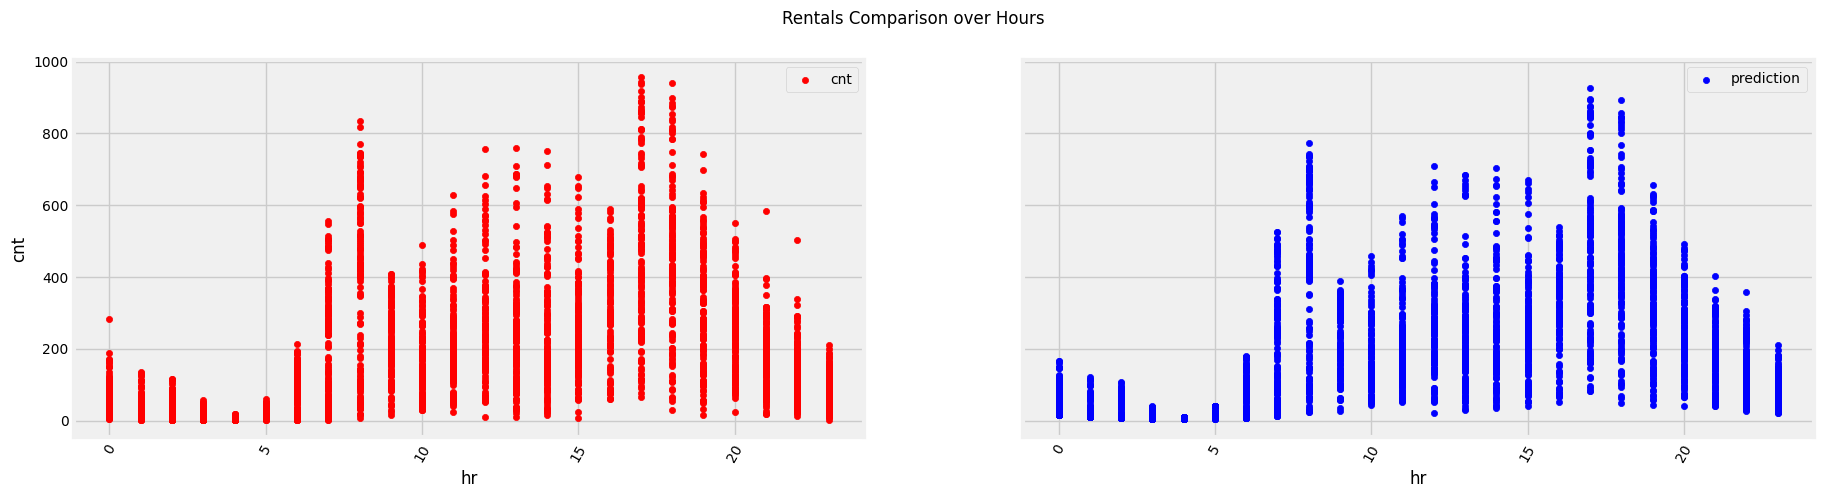

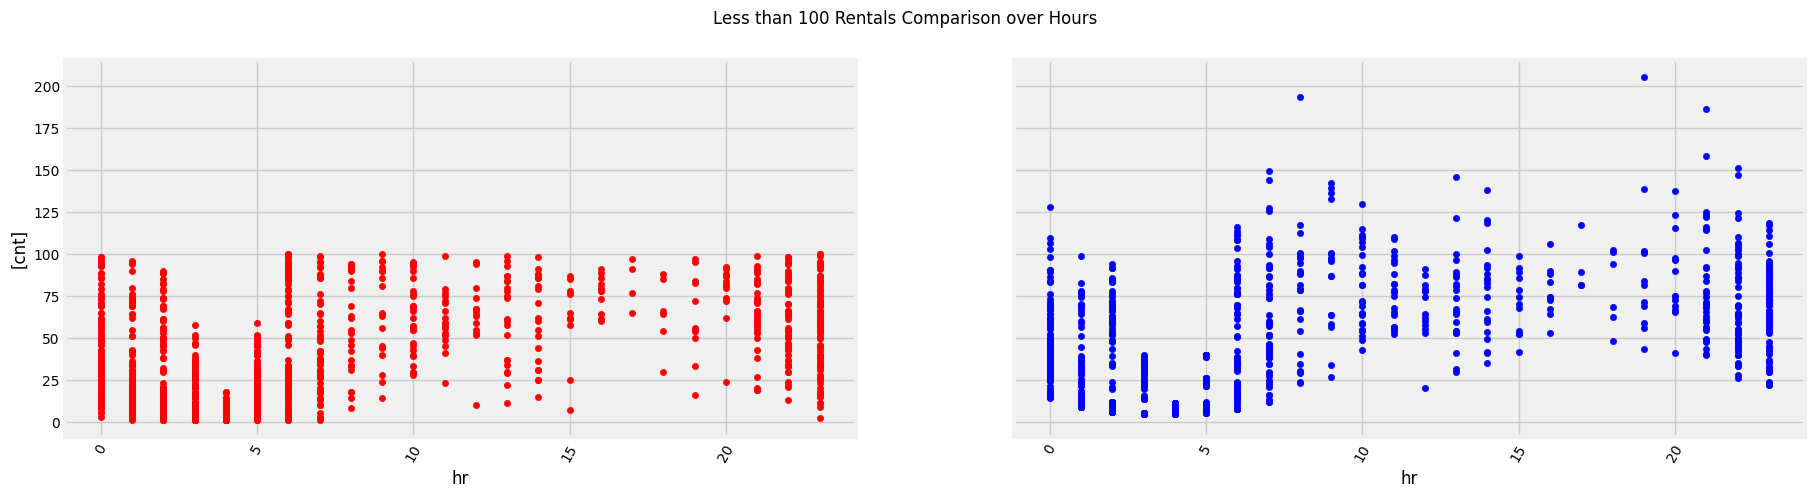

In [32]:
fig, ax = plt.subplots(figsize=(10,5), dpi=100)
best_predictions.plot.line(ax=ax, x='dteday', y=['cnt', 'prediction'], rot=60, style={'cnt': 'ro', 'prediction': 'bo'}, linewidth=1, markersize=3)

fig, ax = plt.subplots(1, 2, figsize=(20,5), sharey=True, dpi=100)
fig.suptitle('Rentals Comparison over Hours')
best_predictions.plot.scatter(ax=ax[0], x='hr', y='cnt', rot=60, color='r', label='cnt')
best_predictions.plot.scatter(ax=ax[1], x='hr', y='prediction', rot=60, color='b', label='prediction')

fig, ax = plt.subplots(1, 2, figsize=(20,5), sharey=True, dpi=100)
fig.suptitle('Less than 100 Rentals Comparison over Hours')
less_than_100.plot.scatter(ax=ax[0], x='hr', y=['cnt'], rot=60, c='r') #, style={'cnt': 'ro', 'prediction': 'bo'}, linewidth=1, markersize=1.5 )
less_than_100.plot.scatter(ax=ax[1], x='hr', y=['prediction'], rot=60, c='b') #, style={'cnt': 'ro', 'prediction': 'bo'}, linewidth=1, markersize=1.5)

plt.show()

In [33]:
print('(MSE) On average off by: {:.2f}'.format(best_predictions['error'].mean()))
print('(STD) Average Variance: {:.4f}'.format((best_predictions['prediction'] - best_predictions['cnt']).std()))

(MSE) On average off by: 17.06
(STD) Average Variance: 28.9540
